<h3>This notebook contains training code of a several neural networks performing the "Region of Interest" (ROI) detection work.</h3>

Its output will be used at later stages to preprocess images being fed to the actual classifier. ROI NN will detect bounding boxes surrounding lesions and another algorithm will crop the images so that the aspect ratio required by InceptionResNetV2 NN is used. On the present dataset, with no augmentation, the best CIoU score was around 85%. The architecture included:

1. Branch layers - attempting to detect some features at a larger scale and also doing the initial downsampling
2. Convolutional layers - for standard feature extraction
3. Two attention modules - so that the model better focuses on the most important features; They are trained so that their dot product is 0 assuring they focus on different things. Using attention modules also stabilized the learning a bit.

This architecture allowed for the above mentioned CIoU score with no overfitting.<br/><br />

<h4>Sidenotes</h4>

Using simple IoU loss made the model get stuck - it wasn't getting any better or worse. Using CIoU makes the model start from a worse starting point but it's learning. Let's see how it does after 1000 epochs.

Implementation idea: [Medium article](https://medium.com/analytics-vidhya/different-iou-losses-for-faster-and-accurate-object-detection-3345781e0bf)
*IoU formulas and more: [Researchgate article](https://www.researchgate.net/figure/CIoU-calculation-conceptualized-The-classification-function-L-cls-only-penalizes-if_fig5_355427005)

In [1]:
import os
import absl.logging
import PIL.Image

import numpy as np
import pandas as pd

from typing import Callable
from tensorflow import keras

from functions.ciou import ciou_loss, ciou_metric
from functions.loading_data import SMALLER_HEIGHT, SMALLER_WIDTH
from functions.plotting import plot_multi_output_history

absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
get_names = lambda root_path: [
    file_name.split('.')[0]
    for dir_path, _, file_names in os.walk(root_path)
    for file_name in file_names
]
get_paths = lambda path: [f'{os.path.join(root, file)}' for root, dirs, files in os.walk(path) for file in files]
base_dir = os.path.join('..', '..', 'data', 'images_original_inception_resnet_v2_200x150_splitted')
train_dir = os.path.join(base_dir, 'training')
valid_dir = os.path.join(base_dir, 'validation')

In [3]:
def get_images_array(paths: list[str]) -> np.ndarray:
    rows = []
    rescale = keras.layers.Rescaling(1./255)

    for path in paths:
        with PIL.Image.open(path) as image:
            image_array = np.asarray(image)
            rescaled_image = rescale(image_array)
            rows.append(rescaled_image)

    return np.array(rows)


train_paths = get_paths(train_dir)
valid_paths = get_paths(valid_dir)
X_train = get_images_array(train_paths)
X_valid = get_images_array(valid_paths)

In [4]:
train_names = set(get_names(train_dir))
valid_names = set(get_names(valid_dir))
metadata_path = os.path.join('..', '..', 'data', 'HAM10000_metadata_ext.csv')
data = pd.read_csv(metadata_path).sort_values(by='image_id')
relevant_cols = ['top', 'left', 'bottom', 'right']
train_df = data[data['image_id'].isin(train_names)][relevant_cols]
valid_df = data[data['image_id'].isin(valid_names)][relevant_cols]
ys_train = train_df.to_numpy().astype(float)
ys_train[:, [0, 2]] /= SMALLER_HEIGHT
ys_train[:, [1, 3]] /= SMALLER_WIDTH
ys_valid = valid_df.to_numpy().astype(float)
ys_valid[:, [0, 2]] /= SMALLER_HEIGHT
ys_valid[:, [1, 3]] /= SMALLER_WIDTH

The below architecture managed to achieve ~85% CIoU score, which is quite nice, but I strive for a higher number. Also, for the most parts it was getting stuck in a local minimum, either on -16% CIoU or 37% CIoU. I tried different weights initialization, lower and higher starting learning rates, different optimizers, adding and removing layers and nothing worked, so I switched to a different architecture. Also, the best models built with this architecture are saved and pushed to the git repo.

In [7]:
def get_baseline_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_conv_module(prev: keras.layers.Layer, filters: int, kernel_size: int) -> keras.layers.Layer:
        x = keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(prev)
        x = keras.layers.Conv2D(filters * 2, kernel_size, padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D()(x)

        return x


    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv_module = get_conv_module(_input, 16, 7)
    conv_module = get_conv_module(conv_module, 32, 5)
    conv_module = get_conv_module(conv_module, 64, 3)
    conv_module = get_conv_module(conv_module, 128, 3)
    conv_module = get_conv_module(conv_module, 256, 3)
    conv_module = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(128, activation='relu')(conv_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [9]:
def run_model(
        model_factory: Callable,
        model_name: str,
        loss: Callable,
        metric: Callable,
        reduction_patience=5,
        monitor='val_ciou_metric'):
    MIN_DELTA = .001
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=monitor,
        mode='max',
        patience=20,
        min_delta=MIN_DELTA)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        mode='max',
        factor=0.95,
        min_delta=MIN_DELTA,
        patience=reduction_patience,
        min_lr=0.0005,
        verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('..', 'models', model_name + '_{epoch}'),
        save_best_only=True)
    tensor_board = keras.callbacks.TensorBoard(log_dir=os.path.join('..', 'tensor_logs', model_name))
    model = model_factory(loss, metric)

    return model.fit(
        X_train,
        ys_train,
        validation_data=(X_valid, ys_valid),
        epochs=500,
        batch_size=64,
        callbacks=[reduce_lr, model_checkpoint, tensor_board, early_stopping])

Using a custom model yields CIoU accuracy on a ~80% level which is unsatisfactory. Let's try inception model next.

In [ ]:
history = run_model(get_baseline_model, f'roi_detection_iou_8', ciou_loss, ciou_metric)

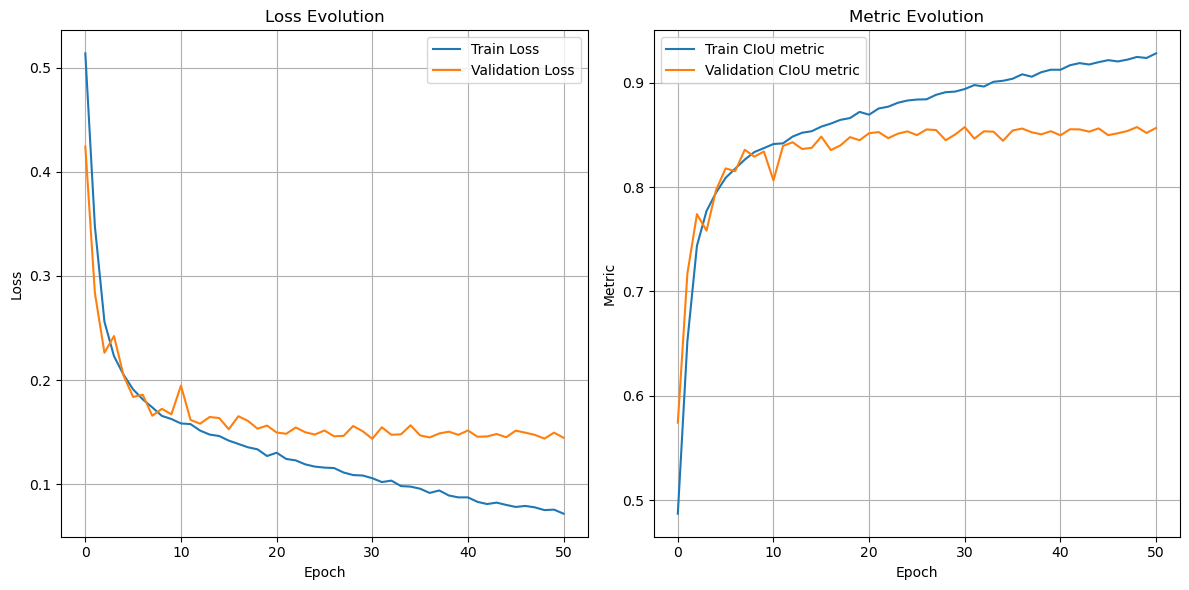

In [10]:
plot_multi_output_history(history)

In [10]:
def get_branched_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch_module(kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(16, kernel_size, padding='same', strides=2, activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_stacked_conv(filters: int, prev: keras.layers.Layer) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(prev)
        conv_module = keras.layers.MaxPooling2D()(conv_module)
        conv_module = keras.layers.Dropout(.2)(conv_module)

        return conv_module

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv1 = get_branch_module(3)
    conv2 = get_branch_module(5)
    conv3 = get_branch_module(7)
    merged = keras.layers.concatenate([conv1, conv2, conv3])
    conv_module = get_stacked_conv(32, merged)
    conv_module = get_stacked_conv(64, conv_module)
    conv_module = get_stacked_conv(128, conv_module)
    flat = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dense(256, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
history2 = run_model(get_branched_model, f'roi_detection_iou_9', ciou_loss, ciou_metric)

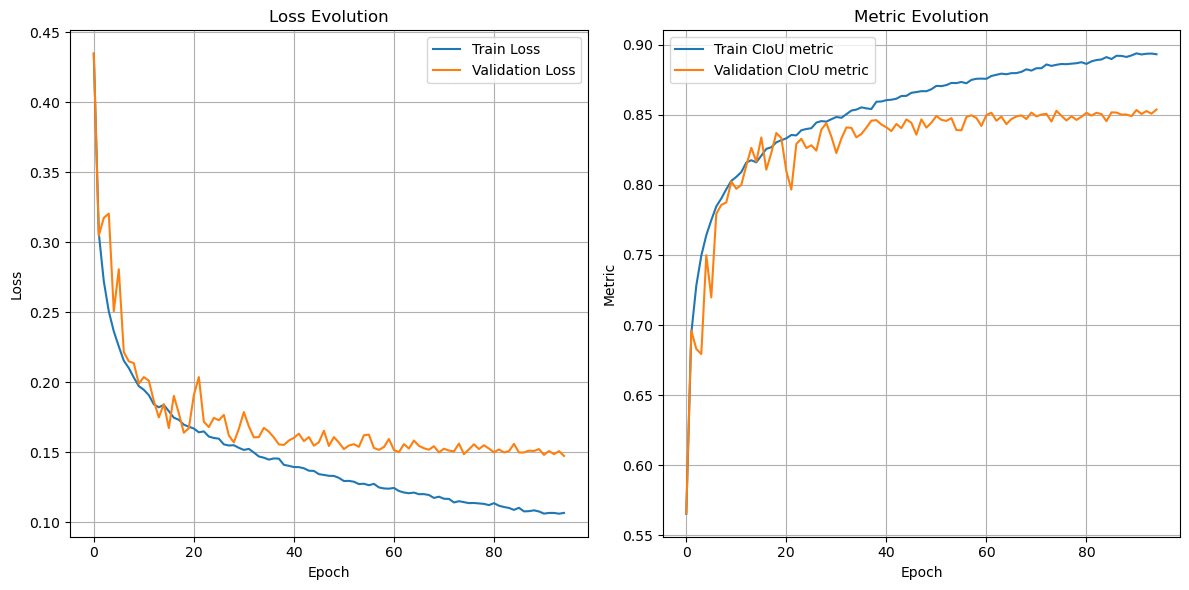

In [13]:
plot_multi_output_history(history2)

In [11]:
def get_branched_model2(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch_module(kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(16, kernel_size, padding='same', strides=2, activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_stacked_conv(filters: int, prev: keras.layers.Layer) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(prev)
        conv_module = keras.layers.MaxPooling2D()(conv_module)
        conv_module = keras.layers.Dropout(.2)(conv_module)

        return conv_module

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv1 = get_branch_module(3)
    conv2 = get_branch_module(5)
    conv3 = get_branch_module(7)
    merged = keras.layers.concatenate([conv1, conv2, conv3])
    conv_module = get_stacked_conv(64, merged)
    conv_module = get_stacked_conv(128, conv_module)
    conv_module = get_stacked_conv(256, conv_module)
    flat = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dense(128, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
history3 = run_model(get_branched_model2, f'roi_detection_iou_10', ciou_loss, ciou_metric)

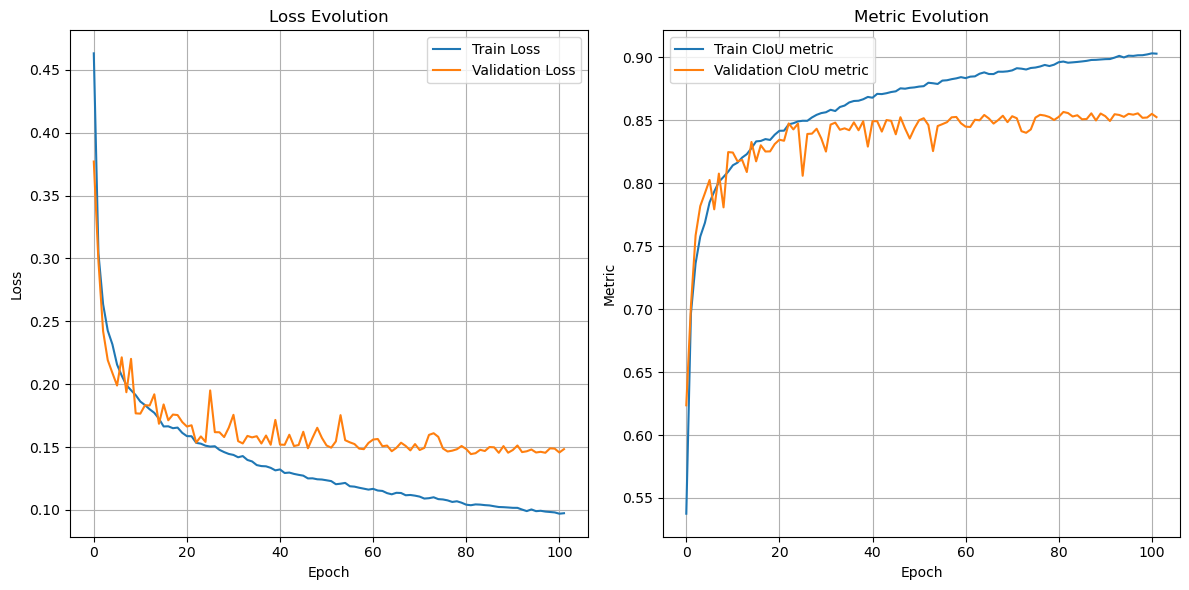

In [14]:
plot_multi_output_history(history3)

In [10]:
def get_branched_model3(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch_module(kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_stacked_conv(filters: int, strides: int, prev: keras.layers.Layer, with_pool = True) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', strides=strides, activation='relu', kernel_initializer=keras.initializers.HeNormal())(prev)

        if with_pool:
            conv_module = keras.layers.MaxPooling2D()(conv_module)

        conv_module = keras.layers.Dropout(.2)(conv_module)

        return conv_module

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv1 = get_branch_module(9)
    conv2 = get_branch_module(7)
    conv3 = get_branch_module(5)
    merged = keras.layers.concatenate([conv1, conv2, conv3])
    conv_module = get_stacked_conv(128, 2, merged)
    conv_module = get_stacked_conv(256, 2, conv_module)
    conv_module = get_stacked_conv(256, 2, conv_module, False)
    flat = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dropout(.3)(locator_module)
    locator_module = keras.layers.Dense(256, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
history4 = run_model(get_branched_model3, f'roi_detection_iou_19', ciou_loss, ciou_metric, 10)

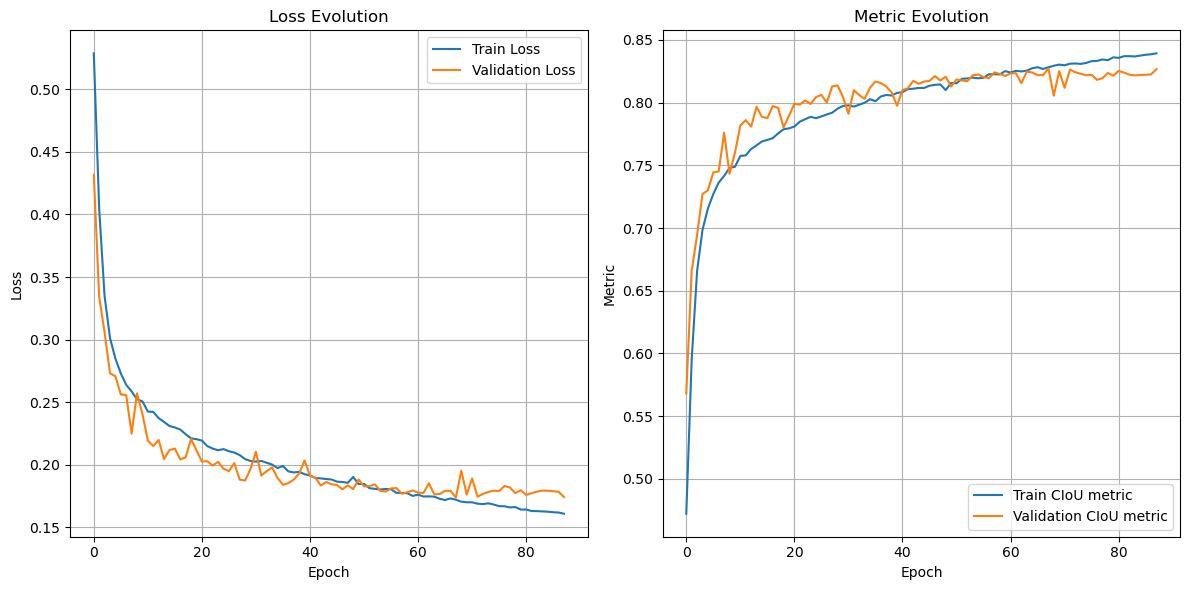

In [12]:
plot_multi_output_history(history4)

In [13]:
def get_branched_model4(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch_module(kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(16, kernel_size, padding='same', strides=2, activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_stacked_conv(filters: int, prev: keras.layers.Layer) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', strides=2, activation='relu')(prev)
        conv_module = keras.layers.MaxPooling2D()(conv_module)
        conv_module = keras.layers.Dropout(.2)(conv_module)

        return conv_module

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv1 = get_branch_module(3)
    conv2 = get_branch_module(5)
    conv3 = get_branch_module(7)
    merged = keras.layers.concatenate([conv1, conv2, conv3])
    conv_module = get_stacked_conv(64, merged)
    conv_module = get_stacked_conv(128, conv_module)
    flat = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
history5 = run_model(get_branched_model4, f'roi_detection_iou_21', ciou_loss, ciou_metric, 10)

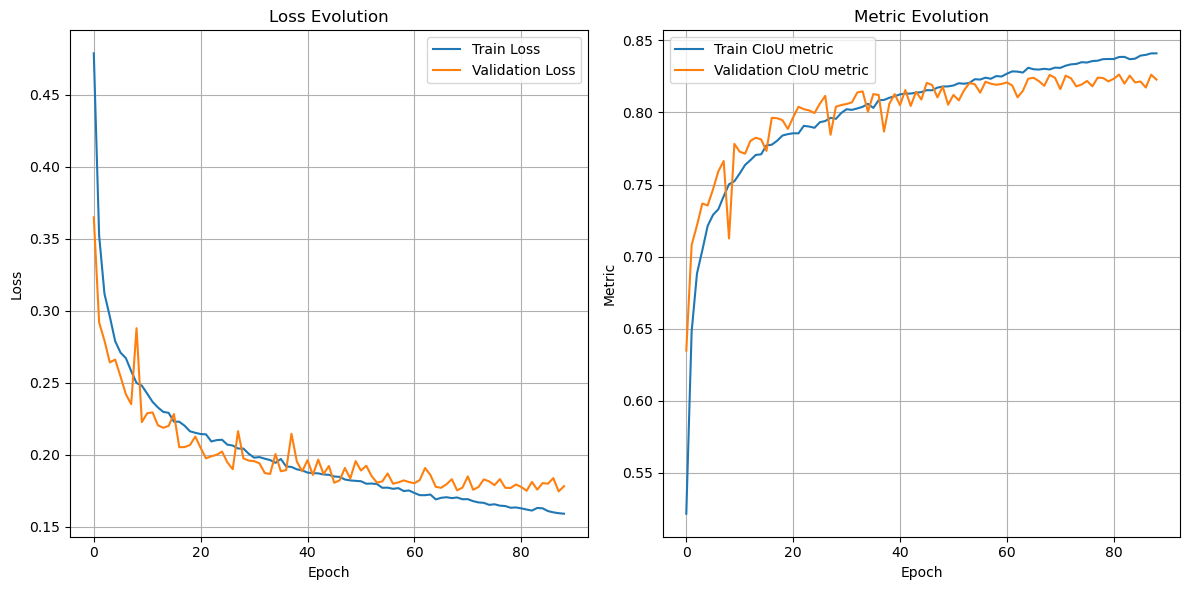

In [15]:
plot_multi_output_history(history5)

After some experimentation with rather simple models it seems that the one created by the get_branched_model2 function reached the highest accuracy somewhere around epoch 23. Let's use that simple architecture and mix it with simple attention mechanisms.

In [19]:
def get_attentive_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch_module(kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(16, kernel_size, padding='same', strides=2, activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_stacked_conv(filters: int, prev: keras.layers.Layer) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(prev)
        conv_module = keras.layers.MaxPooling2D()(conv_module)
        conv_module = keras.layers.Dropout(.2)(conv_module)

        return conv_module

    def get_attention_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D()(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 256))(gap_layer)
        dense1 = keras.layers.Dense(256, activation='relu')(gap_layer_res)
        dense2 = keras.layers.Dense(256, activation='softmax')(dense1)
        mul_layer = keras.layers.Multiply()([conv_module, dense2])

        return mul_layer

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv1 = get_branch_module(3)
    conv2 = get_branch_module(5)
    conv3 = get_branch_module(7)
    merged = keras.layers.concatenate([conv1, conv2, conv3])
    conv_module = get_stacked_conv(64, merged)
    conv_module = get_stacked_conv(128, conv_module)
    conv_module = get_stacked_conv(256, conv_module)
    attention_module = get_attention_module(conv_module)
    flat = keras.layers.Flatten()(attention_module)
    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dense(128, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [ ]:
history6 = run_model(get_attentive_model, f'roi_detection_iou_25', ciou_loss, ciou_metric, 20)

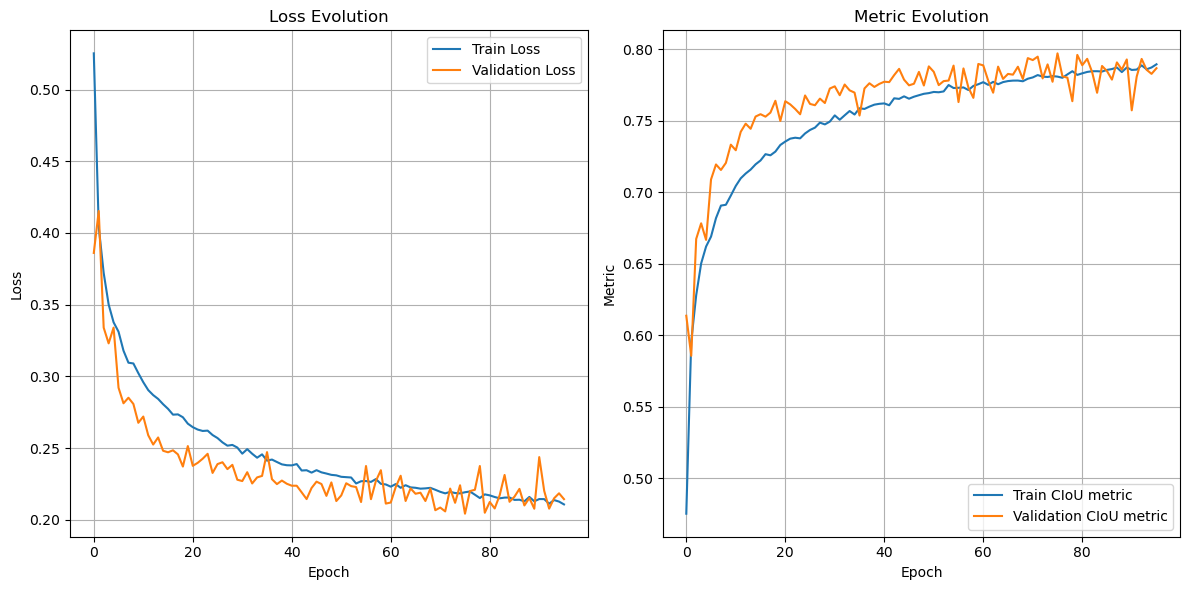

In [21]:
plot_multi_output_history(history6)

In [11]:
def run_multi_attentive_model(
        model_factory: Callable,
        model_name: str,
        loss: Callable,
        metric: Callable,
        reduction_patience=5,
        monitor='val_root_ciou_metric'):
    MIN_DELTA = .001
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=monitor,
        mode='max',
        patience=20,
        min_delta=MIN_DELTA)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        mode='max',
        factor=0.95,
        min_delta=MIN_DELTA,
        patience=reduction_patience,
        min_lr=0.0005,
        verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('..', 'models', model_name + '_{epoch}'),
        save_best_only=True)
    tensor_board = keras.callbacks.TensorBoard(log_dir=os.path.join('..', 'tensor_logs', model_name))
    model = model_factory(loss, metric)

    return model.fit(
        X_train,
        {'root': ys_train, 'dot': np.zeros((len(ys_train,),))},
        validation_data=(X_valid, {'root': ys_valid, 'dot': np.zeros((len(ys_valid,),))}),
        epochs=500,
        batch_size=64,
        callbacks=[reduce_lr, model_checkpoint, tensor_board, early_stopping])

In [4]:
def get_attentive_model2(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch(_input: keras.layers.Layer, kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(128, kernel_size, padding='same', strides=2, activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_inner_conv_module(prev: keras.layers.Layer, filters: int) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(prev)
        conv_module = keras.layers.MaxPooling2D()(conv_module)
        conv_module = keras.layers.Dropout(.4)(conv_module)

        return conv_module

    def get_outer_conv_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        conv_module = get_inner_conv_module(prev, 64)
        conv_module = get_inner_conv_module(conv_module, 128)
        conv_module = get_inner_conv_module(conv_module, 256)

        return conv_module

    def get_attention_module(prev: keras.layers.Layer, num: int) -> keras.layers.Layer:
        gap_layer = keras.layers.GlobalAveragePooling2D(name=f'attention_gap_{num}')(prev)
        gap_layer_res = keras.layers.Reshape((1, 1, 256))(gap_layer)
        dense = keras.layers.Dense(256, activation='relu')(gap_layer_res)
        dense = keras.layers.Dense(256, activation='softmax')(dense)
        mul_layer = keras.layers.Multiply()([prev, dense])

        return mul_layer

    def get_locator_module(prev: keras.layers.Layer) -> keras.layers.Layer:
        locator_module = keras.layers.Flatten()(prev)
        locator_module = keras.layers.Dense(256, activation='relu')(locator_module)
        locator_module = keras.layers.Dense(128, activation='relu')(locator_module)

        return locator_module

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    branch1 = get_branch(_input, 3)
    branch2 = get_branch(_input, 5)
    branch3 = get_branch(_input, 7)
    merged_branches = keras.layers.concatenate([branch1, branch2, branch3])
    conv_module = get_outer_conv_module(merged_branches)
    attention_module1 = get_attention_module(conv_module, 1)
    attention_module2 = get_attention_module(conv_module, 2)
    merged_attentions = keras.layers.concatenate([attention_module1, attention_module2])
    locator_module = get_locator_module(merged_attentions)
    output = keras.layers.Dense(4, activation='sigmoid', name='root')(locator_module)
    gap_attention1 = keras.layers.GlobalAveragePooling2D()(attention_module1)
    gap_attention2 = keras.layers.GlobalAveragePooling2D()(attention_module2)
    aux_output = keras.layers.Dot(axes=1, normalize=True, name='dot')([gap_attention1, gap_attention2])
    model = keras.Model(_input, outputs=[output, aux_output])

    model.compile(
        optimizer='adam',
        loss={
            'root': loss,
            'dot': keras.losses.mean_squared_error,
        },
        loss_weights={'root': 1.0, 'dot': 0.1},
        metrics={
            'root': metric,
            'dot': keras.metrics.mean_squared_error
        })

    print(model.summary())

    return model

In [ ]:
get_attentive_model2(ciou_loss, ciou_metric)

In [ ]:
history7 = run_multi_attentive_model(get_attentive_model2, f'roi_detection_iou_26', ciou_loss, ciou_metric, 20)

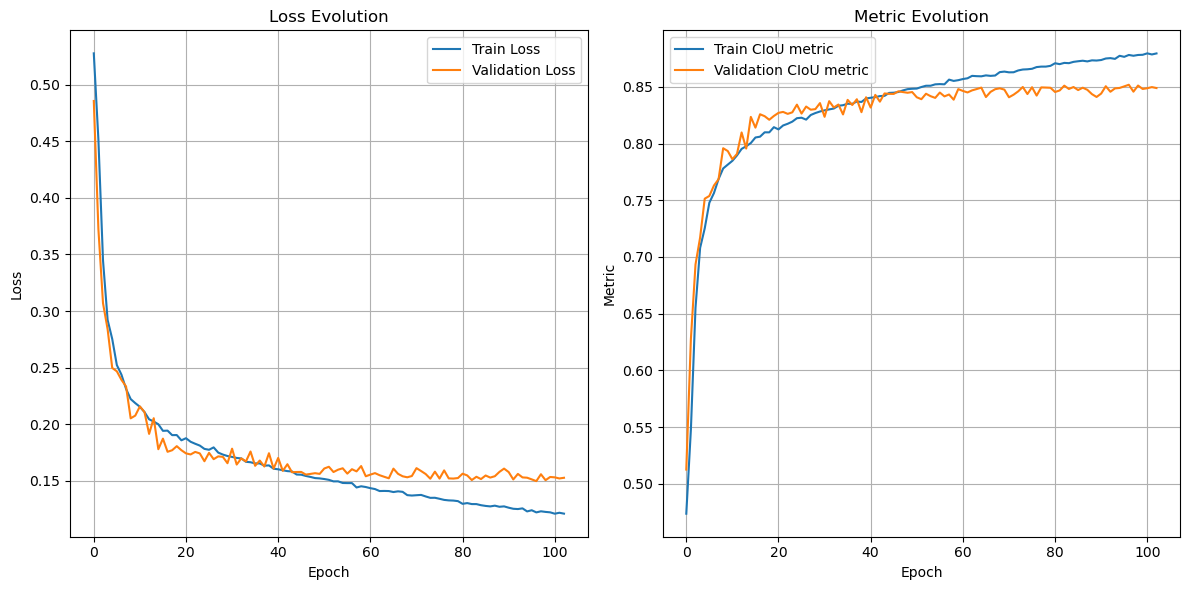

In [15]:
plot_multi_output_history(history7, metric_key='root_ciou_metric', val_metric_key='val_root_ciou_metric')